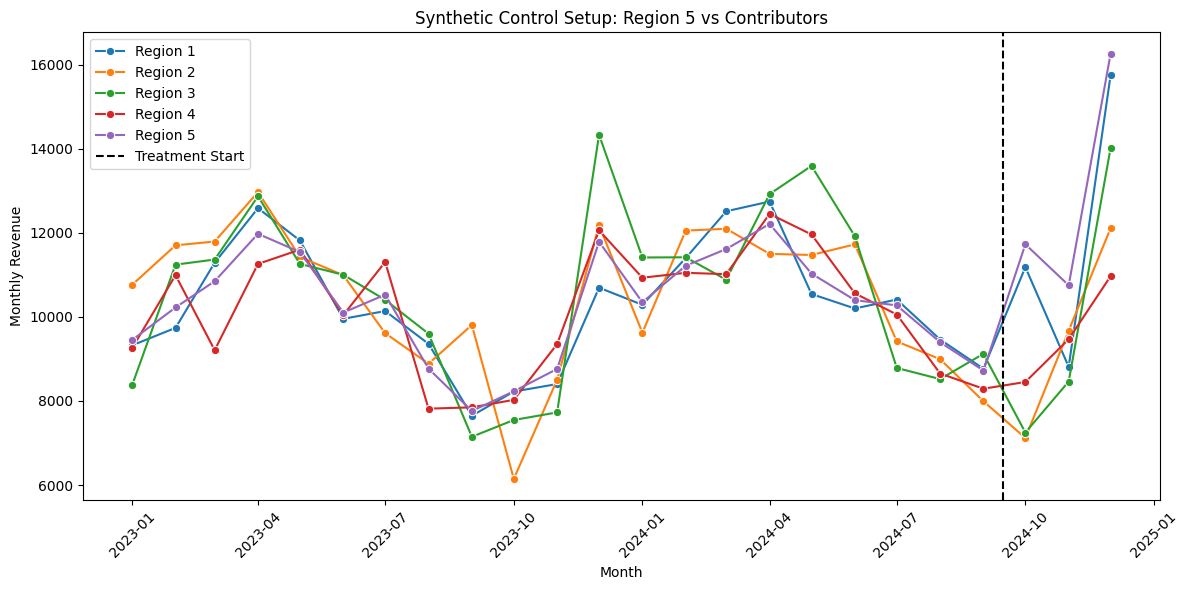

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed
np.random.seed(42)

# Create monthly range over two years
months = pd.date_range(start="2023-01-01", end="2024-12-01", freq="MS")
n_regions = 10

# Create base DataFrame: all region-month combinations
data = pd.DataFrame([(month, f"Region {i+1}") for i in range(n_regions) for month in months],
                    columns=["Month", "Region"])
data["Month_Num"] = data["Month"].dt.month

# Assign each region a volatility multiplier
volatility = {f"Region {i+1}": np.random.uniform(0.8, 1.2) for i in range(n_regions)}
data["Volatility"] = data["Region"].map(volatility)

# Add components to simulate revenue
data["Seasonality"] = 2000 * np.sin((data["Month_Num"] - 1) / 12 * 2 * np.pi) * data["Volatility"]
data["HolidayBump"] = np.where(data["Month_Num"] == 12, np.random.uniform(2000, 6000, size=len(data)), 0)
data["Noise"] = np.random.normal(0, 800, size=len(data))
data["BaseRevenue"] = 10000 + data["Seasonality"] + data["HolidayBump"] + data["Noise"]

# Pivot to wide format for synthetic control calculation
df_wide = data.pivot(index="Month", columns="Region", values="BaseRevenue")

# Make Region 10 a synthetic control: weighted average of Regions 1, 4, and 7
weights = [0.5, 0.3, 0.2]
df_wide["Region 5"] = (
    weights[0] * df_wide["Region 1"] +
    weights[1] * df_wide["Region 4"] +
    weights[2] * df_wide["Region 7"]
)

# Apply a 10% treatment effect to Region 10 starting Oct 2024
df_wide.loc[df_wide.index >= "2024-10-01", "Region 5"] *= 1.20

# Convert back to long format
df_long = df_wide.reset_index().melt(id_vars="Month", var_name="Region", value_name="Revenue")

# Optional: plot Region 10 vs synthetic contributors
plot_df = df_long[df_long["Region"].isin(["Region 1", "Region 2", "Region 3", "Region 4", "Region 5"])]
plt.figure(figsize=(12, 6))
sns.lineplot(data=plot_df, x="Month", y="Revenue", hue="Region", marker="o")
plt.axvline(pd.to_datetime("2024-09-15"), color="black", linestyle="--", label="Treatment Start")
plt.title("Synthetic Control Setup: Region 5 vs Contributors")
plt.ylabel("Monthly Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

In [5]:
df_wide["R5_baseline"] = (
    weights[0] * df_wide["Region 1"] +
    weights[1] * df_wide["Region 4"] +
    weights[2] * df_wide["Region 7"]
)

# Confirm 20% increase in Q4 2024 data 
print(f"Realized Revenue: {df_wide.loc[df_wide.index >= '2024-10-01', 'Region 5'].mean()}")
print(f"Baseline Revenue: {df_wide.loc[df_wide.index >= '2024-10-01', 'R5_baseline'].mean()}")

print(df_wide.loc[df_wide.index >= "2024-10-01", "Region 5"].sum() / 
      df_wide.loc[df_wide.index >= "2024-10-01", "R5_baseline"].sum())

# Calculate average monthly revenue gain:
print(df_wide.loc[df_wide.index >= "2024-10-01", "Region 5"].mean() - 
      df_wide.loc[df_wide.index >= "2024-10-01", "R5_baseline"].mean())


df_wide = df_wide.drop(columns="R5_baseline")
df_wide = df_wide[[col for col in df_wide.columns if col != "Region 10"] + ["Region 10"]]
df_wide.reset_index().to_csv("../data/synthetic_control_revenue_data.csv", index=False)

Realized Revenue: 12912.553532963806
Baseline Revenue: 10760.461277469838
1.2
2152.092255493968
